# Convex Hull Continuum Removal

This notebook reads the hyperspectral mosaic, calculates a convex hull and outputs a convex hull continuum removed data set.

In [3]:
# import standard libaries
import os, warnings, subprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# import gis libraries
import rasterio
from rasterio.windows import Window

# import key scipy modules
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d

# filter warnings for tidy output
warnings.filterwarnings("ignore")

## 1. Run Convex Hull Removal

This is a pretty slow workflow that runs a pixel-wise convex hull removal processing step inspired by Ben Chi's [*Reading TSG Files*](https://www.fractalgeoanalytics.com/articles/reading-tsg-files/) blogpost. Spectra needed to be modified slightly before a convex hull could be fitted so as to ensure weirdly low reflactance values at around 1390.4nm were not lower than the reflectivity at the first and last wavelength.

In [4]:
# set path to mosaic ENVI grid
hsi_fn = r'/storage/gsq_hymap/processed/GSQ_block-d_mosaic_ref.dat'

# set path to output convex hull continuum removed ENVI grid
cvx_fn = r'/storage/gsq_hymap/outputs/GSQ_block-d_mosaic_hull.dat'

In [3]:
# open the ENVI
with rasterio.open(hsi_fn,'r') as src:
  # create a metadata file for the output
  meta = src.meta.copy()
  meta.update({'dtype':'int16', 'driver':'ENVI', 'nodata':-999})
  # get a numpy array of the wavelegnths for each band, use band descriptions
  wvl = np.array([float(x.strip('nm')) for x in src.descriptions])
  # open the output file
  with rasterio.open(cvx_fn,'w',**meta) as dst:
    # iterate through the native blockwindows (rows in ENVI grids)
    blockwindows = [x for x in src.block_windows()]
    for ji, block in tqdm(blockwindows):
      hsi_window = src.read(window=block)[:,0,:].T    # reshape window to (Npixels, Nwavelengths)
      # iterate through pixels in blockwindow and perform convex hull continuum removal 
      cvxhul_window = hsi_window.copy()
      for i, pix in enumerate(hsi_window):
        if pix[0] != src.nodata: # only consider non-nodata pixels
          pix[pix < 0] = 0                                # set negative reflectivities of zero  
          pix[0], pix[-1] = -1, -1                        # set the first and last wavelength reflectivity values to -1
          cvxhul = ConvexHull(np.vstack([pix, wvl]).T)    # fit convex hull object to the modified spectrum
          vtx = np.sort(cvxhul.vertices)                  # get sorted vertices of the hull
          f = interp1d(wvl[vtx], pix[vtx])                # fit a scipy inter1d linear interpolator to hull vertices
          hull = f(wvl)                                   # linear interpolation of the hull for all wavelengths 
          cvxhul_window[i] = pix - hull                   # remove hull from spectrum and place in output window
      # write the convex hull removed data to the output file
      dst_out = np.zeros((wvl.shape[0],1,cvxhul_window.shape[0]), dtype=cvxhul_window.dtype)
      dst_out[:,0,:] = cvxhul_window.T
      dst.write(dst_out, window=block)
    # write band descriptions
    for i, d in enumerate(src.descriptions):
      dst.set_band_description(i+1, src.descriptions[i])
    dst.close()
  src.close()

100%|██████████| 7285/7285 [3:13:31<00:00,  1.59s/it]  


## 2. Visualise Results

Plot an arbitrary window of pixels from the raw and convex hull removed data cubes to confirm the above has worked. Plot a composite RGB image with Fe3+ sensitive wavelength (~900nm) in the red channel, AlOH sensitive wavelength (~2200nm) in the green channel and CO3 sensitive wavelength (~2300nm) in the blue channel.

In [7]:
# read a 1500 by 1500 pixel window from the raw and convex hull mosaics
read_win = Window(4000, 1500, 2000, 2000)
raw_win = rasterio.open(hsi_fn,'r').read(window=read_win)
cvx_win = rasterio.open(cvx_fn,'r').read(window=read_win)

# get indices for wavelengths of interest 
plt_idx = [np.argmin(abs(wvl-900)), np.argmin(abs(wvl-2200)), np.argmin(abs(wvl-2300))]
f'Fe3+, AlOH and CO3 sensitive bands: {plt_idx} with wavelenghts: {wvl[plt_idx]}'

([32, 107, 113], array([ 906. , 2193.1, 2298.8]))

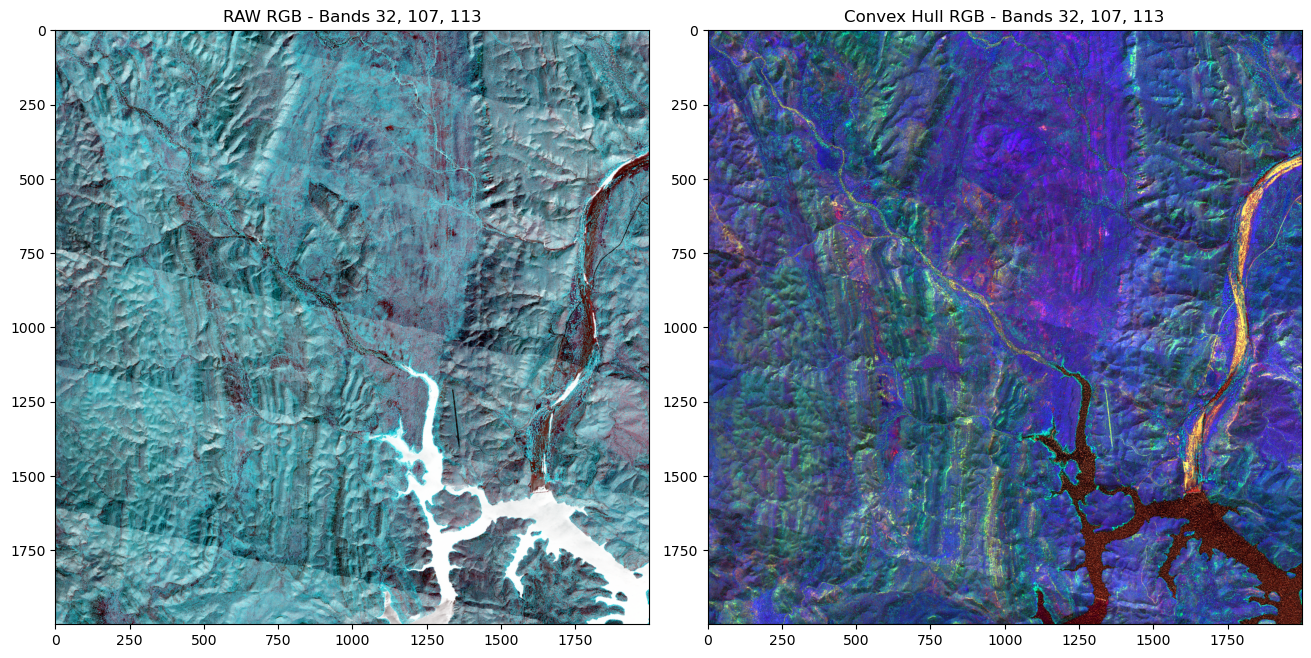

In [9]:
# plot both windows
fig, axes = plt.subplots(1,2,figsize=(13,7), constrained_layout=True)
titles = [f'RAW RGB - Bands {plt_idx[0]}, {plt_idx[1]}, {plt_idx[2]}', f'Convex Hull RGB - Bands {plt_idx[0]}, {plt_idx[1]}, {plt_idx[2]}']
for d, ax, t in zip([raw_win, cvx_win], axes, titles):
  # read plotting bands, change dtype
  d = d[plt_idx].copy().astype('float32')
  # scale each band to 99.9th percentile
  for i in range(3):
    low, high = np.percentile(d[i],0.5), np.percentile(d[i],99.5)
    d[i,d[i] < low],  d[i,d[i] > high] = low, high
    d[i] = -(d[i] - d[i].max()) / (d[i].max() - d[i].min())
  # plot the data
  ax.imshow(np.moveaxis(d,0,-1))
  ax.set(title=t)
plt.show()

Plot a random selection of pixels from window showing the raw spectrum and the convex hull continuum removed spectrum for each.

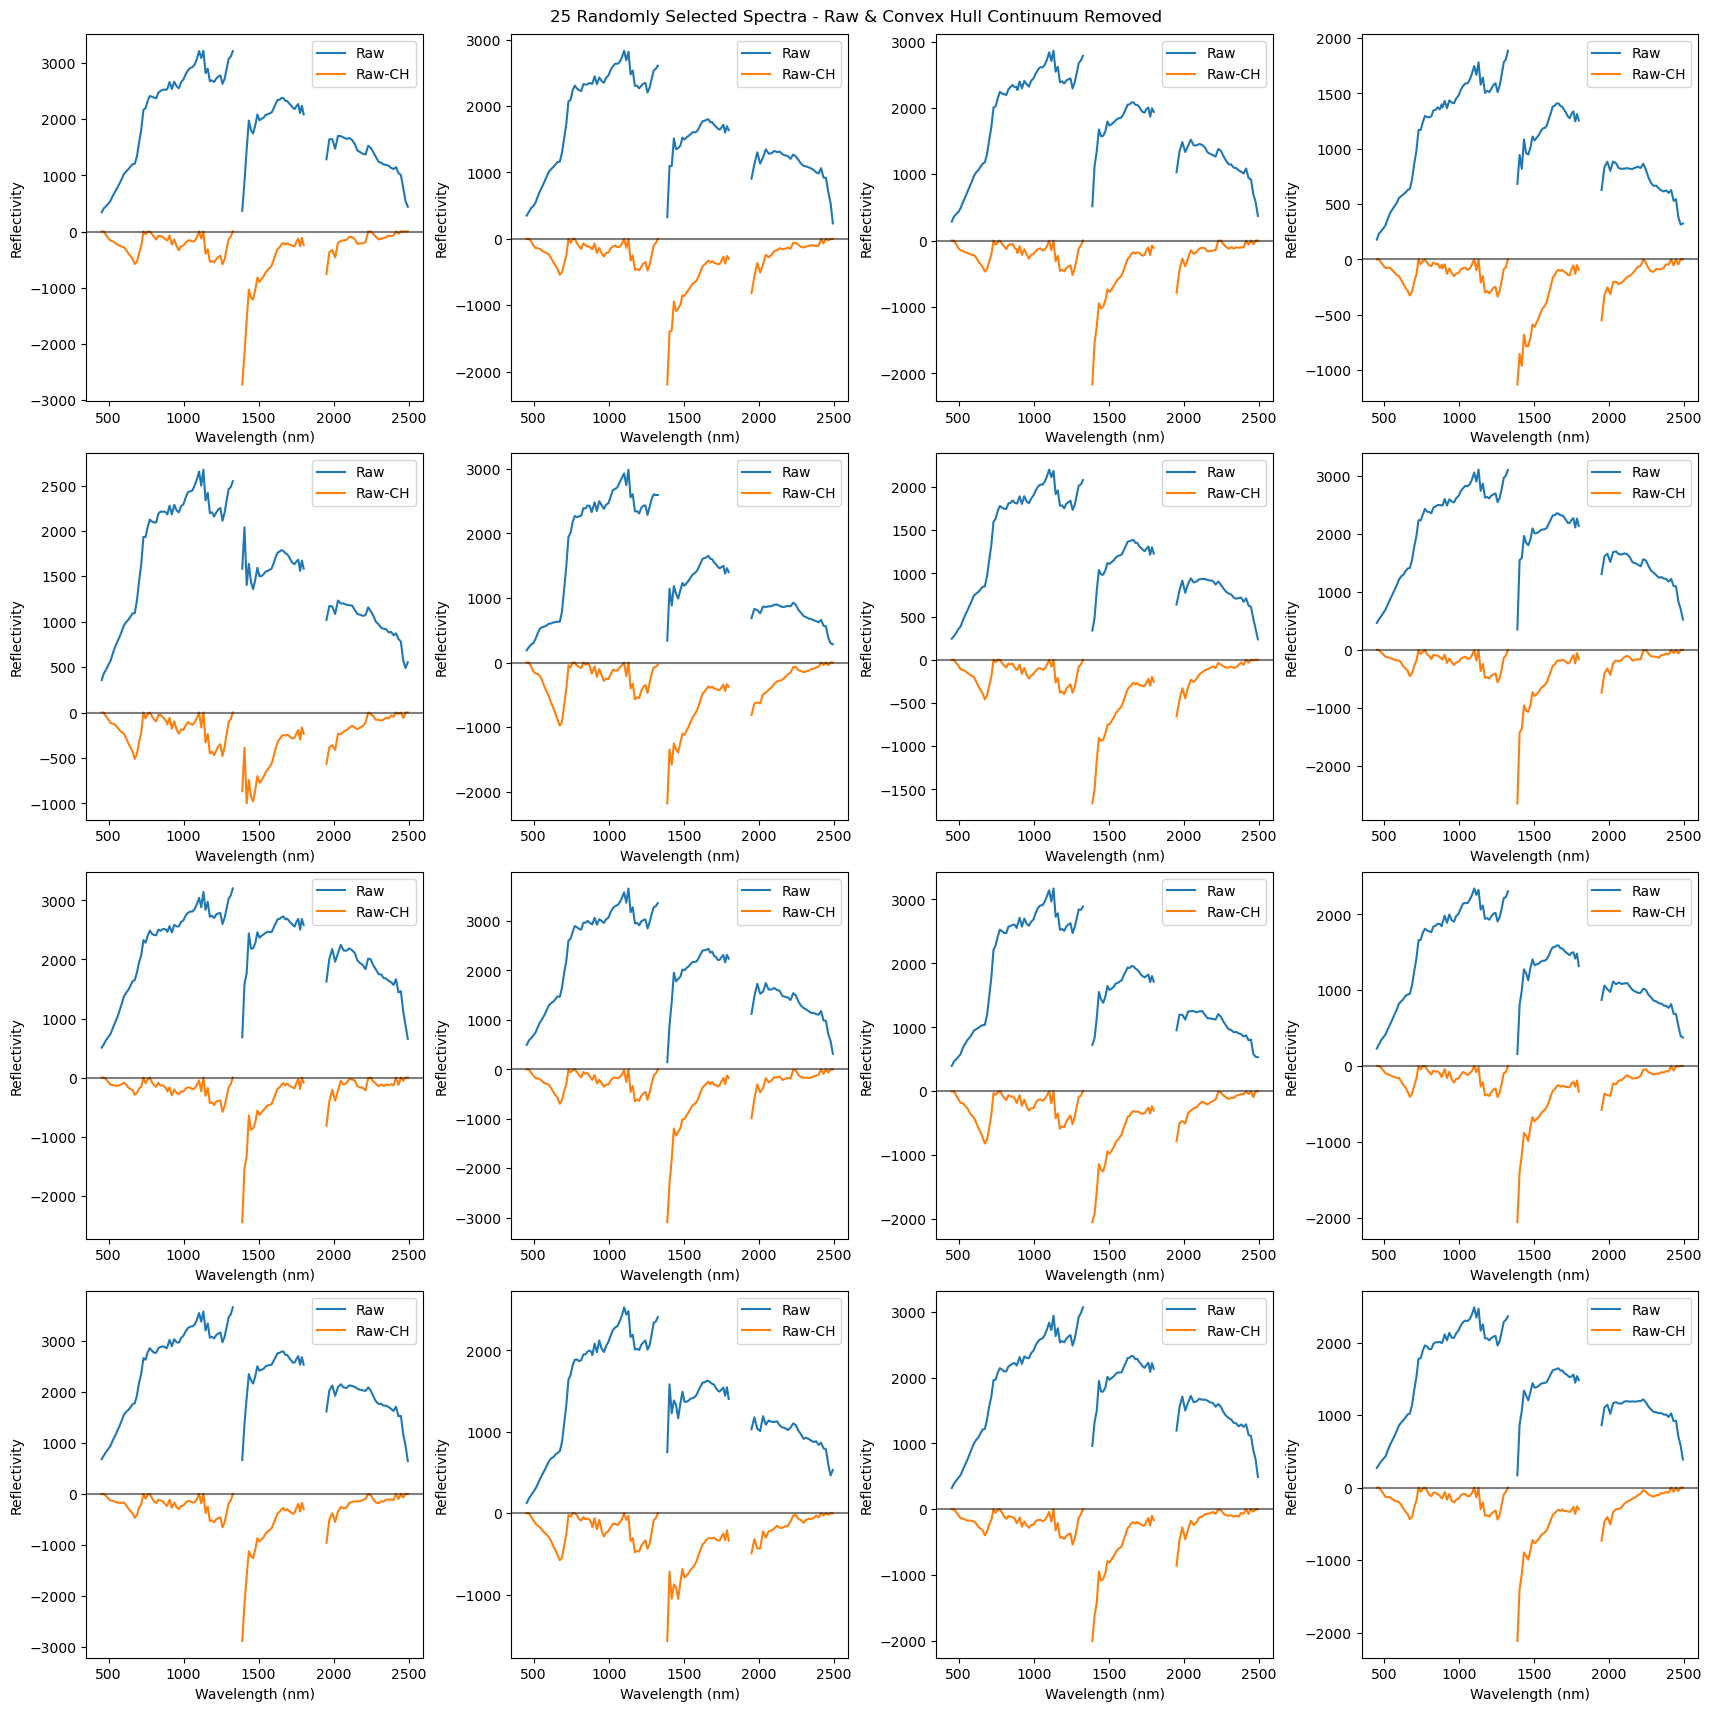

In [34]:
# convert the 3D window of spectral information to a 2D array with shape (Npixels, Nwavelengths)
raw_pix = raw_win.reshape((raw_win.shape[0], raw_win.shape[1] * raw_win.shape[2])).T
cvx_pix = cvx_win.reshape((cvx_win.shape[0], cvx_win.shape[1] * cvx_win.shape[2])).T

# generate a random sampling index for plotting
rand_idx = np.random.choice(np.arange(raw_pix.shape[0]), 16, replace=False)

# plot 25 raw and convex hull removed spectra excluding the atmospheric absorption bands
fig, axes = plt.subplots(4,4,figsize=(17,17), constrained_layout=True)
for i, ax in zip(rand_idx, axes.flatten()):
  # plot raw data without atmospheric windows
  ax.plot(wvl[wvl<1390], raw_pix[i][wvl<1390], c='tab:blue')
  ax.plot(wvl[(wvl>1390) * (wvl<1951)], raw_pix[i][(wvl>1390) * (wvl<1951)], c='tab:blue')
  ax.plot(wvl[(wvl>1951)], raw_pix[i][(wvl>1951)], c='tab:blue', label='Raw')
  # plot the convex hull corrected spectra without atmospheric windows
  ax.plot(wvl[wvl<1390], cvx_pix[i][wvl<1390], c='tab:orange')
  ax.plot(wvl[(wvl>1390) * (wvl<1951)], cvx_pix[i][(wvl>1390) * (wvl<1951)], c='tab:orange')
  ax.plot(wvl[(wvl>1951)], cvx_pix[i][(wvl>1951)], c='tab:orange', label='Raw-CH')
  # set axis titles etc
  ax.axhline(0, color='k', alpha=0.5)
  ax.set(ylabel='Reflectivity', xlabel='Wavelength (nm)')
  ax.legend()
  fig.suptitle('25 Randomly Selected Spectra - Raw & Convex Hull Continuum Removed')
plt.show()